In [220]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as sp

x = np.load('X_77.npy', allow_pickle = True)
y = np.load('y_77.npy', allow_pickle = True)
a = np.load('alphas_77.npy', allow_pickle = True)

# 3. Constructing the matrix X #

In [24]:
def construct_X(M, alpha, Np = None):
    h = 1
    #Convert alpha to radians
    alpha  = alpha*np.pi/180.0
    #Define Np in case is none
    if Np is None:
        Np = int(sqrt(2)*M)
        if Np%2 == 0:
            Np += Np
        
    #Normal Vector defining orientation and centers of pixels
    n = np.stack((np.cos(alpha),np.sin(alpha))).transpose()
    centers = np.mgrid[0:M,0:M]*h
    #Move the coordintates to the origin, which is on the center
    c_x = centers[0].flatten()-int(M/2)*h
    c_y = -1*(centers[1].flatten()-int(M/2)*h)
    centers_flat = np.stack((c_x,c_y))
    
    #calculate distance as projection and determine previous and next pixel of the sensor
    projection = np.matmul(n,centers_flat)+int(Np/2)*h
    previous_pixel = np.floor(projection)
    next_pixel = previous_pixel+1
    
    weight_previous = (next_pixel-projection)/h
    weight_next = (projection-previous_pixel)/h
    
    j_index = previous_pixel+Np*np.arange(len(alpha))[:,np.newaxis]
    j_next_index = next_pixel+Np*np.arange(len(alpha))[:,np.newaxis]
    
    weight = np.concatenate((weight_previous.flatten(),weight_next.flatten()))
    j = np.concatenate((j_index.flatten(),j_next_index.flatten()))
    
    i = (centers[0]+M*centers[1]).flatten()
    #Repeat the i for each angle times two (because one image pixel affects two sensor pixel)
    i = np.tile(i,2*len(alpha)).flatten()
    D = M**2
    X = sparse.coo_matrix((weight,(j,i)), shape = (Np*len(alpha),D), dtype = np.float32)
    return X

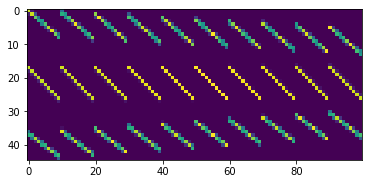

In [25]:
M = 10
Np = 15
a_test = np.array([-33,1,42])
test = construct_X(M,a_test,Np)
plt.imshow(test.todense())

(45, 100)


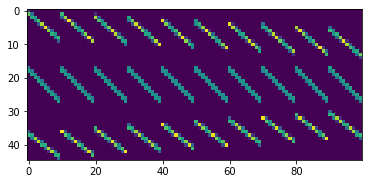

In [26]:
X_s = np.load('X_example.npy', allow_pickle = True)
print(X_s.shape)
plt.imshow(X_s)

<span style="color:green">
<strong>
The basic functionalities are the same as in the sample solution: The positions of the pixels are projected onto the axis defined by the sensor array (the only difference is that we rotate the sensor while the sample solution rotates the pixels). Afterwards the weights of each image pixel for the corresponding sensor pixels are computed. A linear dependency of the weight on the position along the projection axis is assumed. Then, the entries are saved in a sparse matrix. We used sparse.coo_matrix for this step and used vectorized funcions, while the sample solution used for-loops and dok_matrix (regarding the slow version) in one function while the other one is vectorized as well.
Even though our final results seems to be correct, there are some small differences between our result for the test data and the "control image". 
    
But we have another solution in our team that exactly reproduces the control image. We could not the find the problem in the code above (see cell below).
</strong>
</span>

In [1]:
######### ALTERNATIVE SOLUTION ####################
def get_coords(M, Np):
    '''
    A function that computes the coordinates for each pixel. The origin is in the center of the image.
    A pixel distance of 1 is assumed.
    
    input:   
        M         An integer, number of pixels in each dimension
        Np        An integer, number of sensor pixels
    output:
        A numpy array of shape (2, M*M), contains coordinates of each pixel
    '''
    y, x = np.mgrid[0:M,0:M]
    x = x.flatten() - (M-1)/2 
    y = -1*(y.flatten() - (M-1)/2)
    
    return np.array([x, y])

def get_ns(alphas):
    '''
    Creates an array of vectors that lies in the straight line defined by the detector.
    These are perpendicular to the corresponding normal vectors.
    
    input:
        alphas    An array containing the rotation angles of the detector
        
    output:
        A numpy array of shape (2, len(alphas)) containing vectors in the straight lines
        defined by the detector.
    '''
    
    return np.array([np.cos(alphas), np.sin(alphas)])    


def construct_X(M, alphas, Np=None):
    #create a value for Np if no value is given
    if (Np == None): Np = int(np.sqrt(2) * M) + 1
        
    alphas = np.pi/180 * np.array(alphas)
    N = Np * len(alphas)
    D = M*M
    
    #compute the pixel coordinates
    C = get_coords(M, Np)
    
    #compute the vectors to project on
    ns = get_ns(alphas)
    
    #do the projection
    p = np.dot(ns.transpose(), C) + (Np-1)/2
    
    #compute j indices
    j_indices1 = np.floor(p)
    j_indices2 = j_indices1+1
    j_indices = np.concatenate((j_indices1, j_indices2), axis=0)
    shift_mask = np.concatenate((np.arange(len(alphas)), (np.arange(len(alphas))))) * Np
    j_shift = np.ones(np.shape(j_indices))*np.array([shift_mask]).transpose() 
    
    #compute i indices
    i_indices = np.ones(np.shape(j_indices)) * np.arange(M*M)
    
    #compute weights
    weights1 = j_indices1 - p + 1
    weights2 = p - j_indices1
    weights = np.concatenate((weights1, weights2), axis=0)
    
    #filter entries with invalid indices
    filter_cond = np.logical_and(j_indices>-1,j_indices<Np)
    weights = weights[filter_cond]
    i_indices = np.array(i_indices[filter_cond], dtype=int)
    j_indices = np.array(j_indices[filter_cond] + j_shift[filter_cond], dtype=int)
    
    #filter entries where weights is zero
    filter_cond = (weights > 1e-14)
    i_indices = i_indices[filter_cond]
    j_indices = j_indices[filter_cond]
    weights = weights[filter_cond]
    
    
    X = sparse.coo_matrix((weights, (j_indices, i_indices)), shape=(N,D), dtype=np.float32)
    
    return X

# 4. Reconstructing the Image #

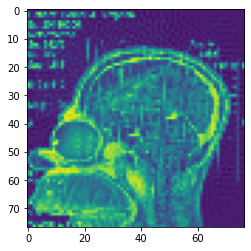

In [27]:
M = 77
Np = 109
X_img = construct_X(M,a,Np)
img = sp.lsqr(X_img,y,atol = 1e-5,btol = 1e-5)[0]
img = np.reshape(img,(M,M))
plt.imshow(img)

The patient has a crayon stuck in his brain


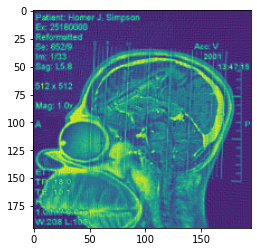

In [28]:
y_true = np.load('y_195.npy', allow_pickle = True)
a_true = np.load('alphas_195.npy', allow_pickle = True)
M = 195
Np = 275
X_img = construct_X(M,a_true,Np)
img = sp.lsqr(X_img,y_true,atol = 1e-5,btol = 1e-5)[0]
img = np.reshape(img,(M,M))
plt.imshow(img)
print('The patient has a crayon stuck in his brain')

<span style="color:green">
<strong>
Our code works equvalently to the sample solution and running it does not need much more time than the sample solution. We did not plot the sinogram, but this was not part of the task, we think.
</strong>
</span>

# 5. Minimizing the dose #

We observe that for 125 projection angles there is some hint of the crayon, and for 150 angles we can clearly resolve it


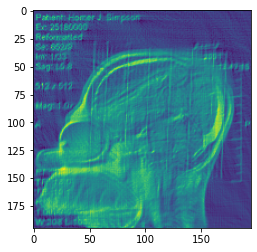

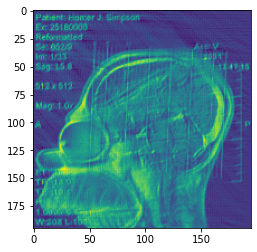

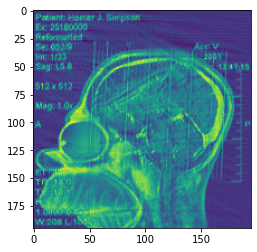

In [29]:
n = [100,125,150]
for N in n:
    a_red = a_true[0:N]
    y_red = y_true[0:N*Np]
    X_img = construct_X(M,a_red,Np)
    img = sp.lsqr(X_img,y_red,atol = 1e-5,btol = 1e-5)[0]
    img = np.reshape(img,(M,M))
    plt.figure()
    plt.imshow(img)
print('We observe that for 125 projection angles there is some hint of the crayon, and for 150 angles we can clearly resolve it')

<span style="color:green">
<strong>
Again, our code has the same functionality as the sample solution, but the number of images we created is lower. But the result how many projections you need to recognize a foreign object differs. This should be okay because there is some ambiguity about the answer to this question.
</strong>
</span>